In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("training.csv", header=None, names=['open', 'high', 'low', 'close'])
data

,open,high,low,close
0,186.73,188.71,186.00,186.30
1,185.57,186.33,184.94,185.54
2,184.81,185.03,183.10,184.66
3,184.39,184.48,182.31,182.54
4,182.20,182.27,180.27,181.59
...,...,...,...,...
1483,151.95,152.20,151.33,151.84
1484,152.06,152.49,151.62,151.98
1485,152.35,152.93,151.70,152.47
1486,152.81,153.61,152.17,153.55


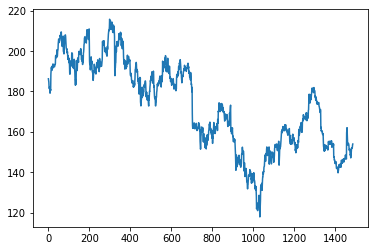

In [2]:
import matplotlib.pyplot as plt

plt.plot(data['close'])

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.iloc[:,3:4].values)
scaled_data.shape

(1488, 1)

In [4]:
# xtrain: data of present-60 to present-1
# ytrain: data of present
xtrain = []
ytrain = []
for i in range(60, len(scaled_data)):
    xtrain.append(scaled_data[i-60:i])
    ytrain.append(scaled_data[i, 0])
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain.shape, ytrain.shape

((1428, 60, 1), (1428,))

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain, ytrain, epochs=100, batch_size=32)

Epoch 1/100
45/45 [==============================] - 15s 62ms/step - loss: 0.0396
Epoch 2/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0080
Epoch 3/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0081
Epoch 4/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0071
Epoch 5/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0074
Epoch 6/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0064
Epoch 7/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0059
Epoch 8/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0068
Epoch 9/100
45/45 [==============================] - 3s 62ms/step - loss: 0.0054
Epoch 10/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0056
Epoch 11/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0052
Epoch 12/100
45/45 [==============================] - 3s 63ms/step - loss: 0.0045
Epoch 13/100
45/45 [====

# TEST

In [6]:
df = pd.read_csv("testing.csv", header=None, names=['open', 'high', 'low', 'close'])
df

,open,high,low,close
0,154.40,155.02,152.91,154.76
1,155.96,156.80,155.07,156.46
2,156.45,156.74,154.68,155.35
3,154.10,156.22,154.09,154.10
4,153.59,154.45,153.26,153.57
5,154.81,155.03,153.55,154.81
6,155.46,155.89,154.57,155.41
7,156.74,157.85,155.16,156.74
8,156.60,156.73,153.89,153.91
9,154.60,155.11,153.70,154.00


In [7]:
rotate = []
for i in range(60):
    rotate.append(xtrain[-1][i][0])
rotate = np.array(rotate).reshape(-1,1)
rotate.shape, type(rotate[0][0])

((60, 1), numpy.float64)

In [20]:
# Append actual stock price to be predicted
ans = []
scaled = scaler.fit_transform(df.iloc[:,3:4].values)
for i in range(len(df)):
    pred = model.predict(rotate.reshape(1,-1))
    pred = scaler.inverse_transform(pred)
    ans.append(pred)
    rotate = np.append(rotate, scaled[i][0])
    rotate = np.delete(rotate, 0)
len(ans)

20

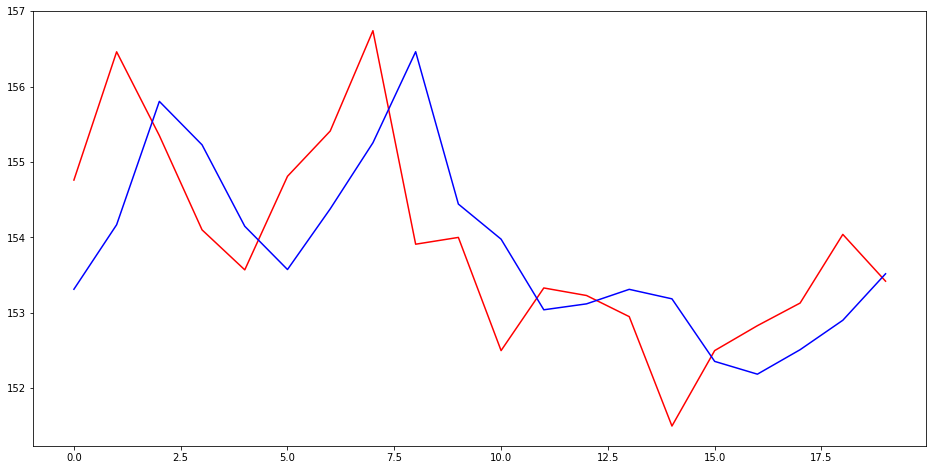

In [9]:
ans = np.array(ans).reshape(-1,1)
plt.figure(figsize=(16,8))
plt.plot(df['close'], color='red')
plt.plot(ans, color='blue')

In [22]:
# Append predicted stock price to be predicted again
ans2 = []
for i in range(len(df)):
    pred = model.predict(rotate.reshape(1,-1))
    pred = scaler.inverse_transform(pred)
    ans2.append(pred)
    rotate = np.append(rotate, pred[0])
    rotate = np.delete(rotate, 0)
len(ans2)

20

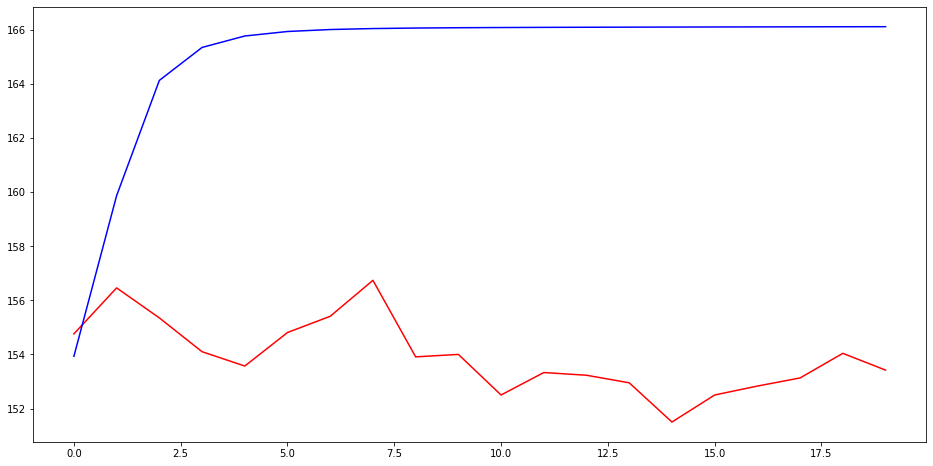

In [24]:
ans2 = np.array(ans2).reshape(-1,1)
plt.figure(figsize=(16,8))
plt.plot(df['close'], color='red')
plt.plot(ans2, color='blue')

In [ ]:
model.save("model.h5")